In [156]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
#sys.path.append(os.path.abspath("/Users/neuroimaging/Desktop/MR-code/Python_Code"))

#from ML_UsefulFunctions import *
#from KidneyROIAnalyses import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format


from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.simplefilter("ignore")


from EllipsoidalSimulationCode import *

from statistics import mean


def func(x,m,b):
    return m*x + b

# Esimation of FA
FA seems to be from about 0.1 to .4

conventional FA (0.19 ± 0.02 and 0.40 ± 0.02) 

https://pubmed.ncbi.nlm.nih.gov/31243814/


combined IVIm and DTI for directionality

https://pubmed.ncbi.nlm.nih.gov/24752998/ Table 2!

## in tissue component:

FA D_tissue cortex = 0.18, medullar = 0.38


## in perfusion component:
FA D_perfusion cortex = 0.09, medullar = 0.41

## in tubular component
guess: tubular would be in between?


# To Do: 

- [x] So given an FA, be able to write up an ellipsoid that has that FA. 

- [x] Assume a tri-component model, give those three components three different FAs

- [x] Build the tri-exponential model (i.e. fraction and TRACE diffusion coefficient)

- [x] Trace is average of the three assumed orthogonal vectors. 

- [x] so for ax, by, cz as the ellipsoid coefficients.... (aDx + bDy + cDz)/3 = D_tr. 

- [x] Think can just be scaling by the radius of a direction... 

- [x] Then for every individual b-value (b_n), rotate ellipsoid and selected the D that would be measured along that direction. 

- [x] Assign that D_n to the given b_n. 

- [x] Plot D_n as a function of b_n 

fit the curve, and see how close it is to true tri-exponential.

# Creating triexp model following Gladytz model

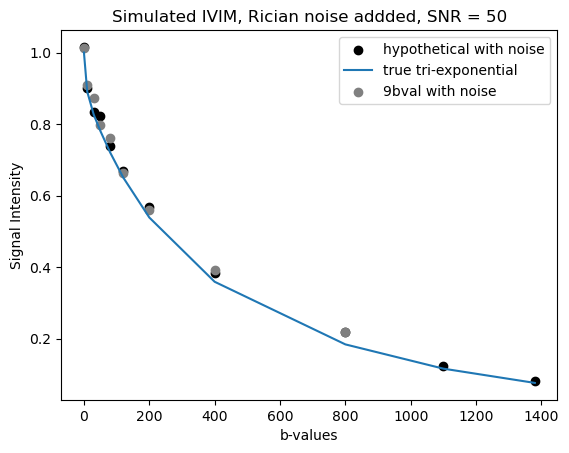

In [2]:
#Diffusion Parameters (Baseline)
diff_fast   = 0.180
diff_med    = 0.0058 #[0.006 0.007 0.008 0.009 0.010];
diff_slow   = 0.0015
frac_fast   = 0.10
frac_med    = 0.30
frac_slow   = 0.60

#hypothetical for the moment
b_values9 = np.array([0,10,30,50,80,120,200,400,800])
#b_values = np.array([0,10,30,50,80,120,200,400,600,800,1000,1200, 1500]) # just large range 13 b values 0 - 1500

b_values11 = np.array([0,10,30,50,80,120,200,400,800, 1100, 1380]) # medium range 11 b values 0 - 1380
 
SI = triexp_func(b_values11,frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow)
SI_9  = triexp_func(b_values9,frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow)
## can also add noise eventually, but not right now?
# or try adding rician from old code

SI_noise = NoiseRice(SI, .02) # with SNR = 50

SI_noise9 = NoiseRice(SI_9, .02) # with SNR = 50

pl.scatter(b_values11,SI_noise,color = 'black', label = 'hypothetical with noise')
pl.plot(b_values11,SI,label = 'true tri-exponential')
pl.title('Simulated IVIM, Rician noise addded, SNR = 50')
pl.xlabel('b-values')
pl.ylabel('Signal Intensity')

pl.scatter(b_values9,SI_noise9,color = 'gray', label = '9bval with noise')
pl.legend()
pl.show()

# Calculation of effect of measuring only one direction
So this is 13 b-values 

say the first 6 are fast component (up to 120)

the next four are mid component (up to 600)

the last three are slow component (800 to 1500)

- first six get 6 different directions of rotation 
- next four get 4 different directions of rotation 
- last 3 get three different directions

so now from each individual point, I need to add or subtract the difference that using one direction randomly chosen would give.

for example, for b = 100, the point is $frac_{fast}e^{(-100*D_tr)}$
I need to make it now $frac_{fast}exp{(-100*D_{\theta_1})}$ where $rot1$ is one direction rotated by some angle. I need to calculate $D_{\theta_n}$ for every $b_n$.

With the ellipsoid, essentially Eq. 1
$$D_{tr} =  \frac{(Dxx +Dyy + Dzz)}{3} = \frac{A_xD + B_yD + C_zD}{3}$$

Where $A_x$, $B_y$, and $C_z$ are the scaled ellipsoid eigenvectors.

So, for a given $\theta_n$, we know $D_{tr} = D_{fast}$ (or slow or med). We know the assumed fractional anisotropy, i.e. $A_x$, $B_y$, and $C_z$. Therefore we solve for D in Eq. 1 and we get $D_{\theta_n}$ by rotating the ellipsoid by $\theta_n$, measuring the x-axis in the rotated frame $x_\theta$ (assumed for this, can choose any of the 3 as long as it's consistent across all $\theta_n$s), and then multiplying by D. This $x_{\theta}D = D_{\theta_n}$


In [3]:
# set the 3 ellipsoids

#  the fast component, estimate FA ~ .09
#  the middle component, estimate FA ~ .12
#  the slow component, estimate FA ~ .18

est_FAS = [.09,.12,.18] #true fractional anisotropy
#est_FAS = [0.0,0.0,0.0] #true fractional anisotropy, proof it is all due to FA... 
D_traces = [diff_fast,diff_med, diff_slow] #true D coefficients


# assume 3 random sets of orientations for fast, middle, and slow compartments
fast_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
med_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
slow_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)

assumed_rots = [fast_rot, med_rot, slow_rot]
#print(assumed_rots)
#b0 is D_tr (no directionality) 

# have 12 b values, (13 w b0) so need 12 different rotations. Then put 
#n = 12
n = 1 #if all done along same directions
thetax = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)
thetay = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)
thetaz = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)

# generate the 3 ellipsoids: 
fast_compartment, med_compartment, slow_compartment = CreateThreeEllipsoidalCompartments(est_FAS,assumed_rots)


#section to run if each b-value has a different direction. not sure if necessary... 
for i in range(n):
    # for ith rotation i.e. ith b-val
    thetaxyz = [thetax[i],thetay[i],thetaz[i]]
    #print(thetaxyz)
    D_single, D_averaged= GetOrthogonalD_thetas(D_traces,fast_compartment, med_compartment, slow_compartment, thetaxyz)
    

    
    

In [4]:
b_values11 = np.array([0,10,30,50,80,120,200,400,800, 1100, 1380]) # medium range 11 b values 0 - 1380


# generate the signal from single direction
Est_signal_single = triexp_func(b_values11,frac_fast,frac_med,frac_slow, D_single[0], D_single[1], D_single[2])
SI_est_noise_single = NoiseRice(Est_signal_single, 0.02)

# generate the signal from 3 averaged direction
Est_signal_averaged = triexp_func(b_values11,frac_fast,frac_med,frac_slow, D_averaged[0], D_averaged[1], D_averaged[2])
SI_est_noise_av = NoiseRice(Est_signal_averaged, 0.02)
    
# generate the signal from true trace direction
Est_signal_true = triexp_func(b_values11,frac_fast,frac_med,frac_slow, D_traces[0], D_traces[1], D_traces[2])
SI_noise = NoiseRice(Est_signal_true, .02)





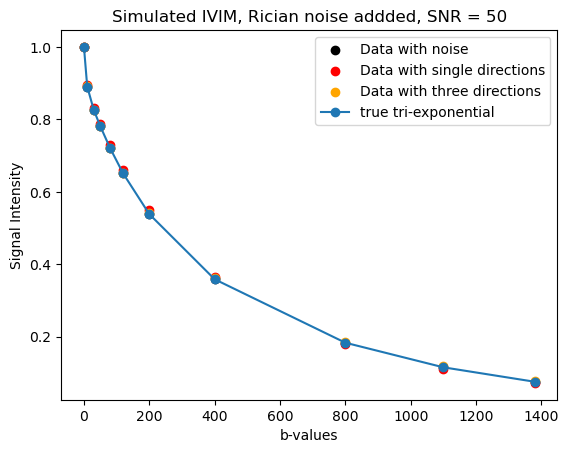

In [5]:
pl.scatter(b_values11,Est_signal_true,color = 'black', label = 'Data with noise')
pl.scatter(b_values11,Est_signal_single,color = 'red', label = 'Data with single directions')
pl.scatter(b_values11,Est_signal_averaged,color = 'orange', label = 'Data with three directions')


pl.plot(b_values11,Est_signal_true,label = 'true tri-exponential', marker = 'o')
pl.title('Simulated IVIM, Rician noise addded, SNR = 50')
pl.xlabel('b-values')
pl.ylabel('Signal Intensity')
pl.legend()
pl.show()

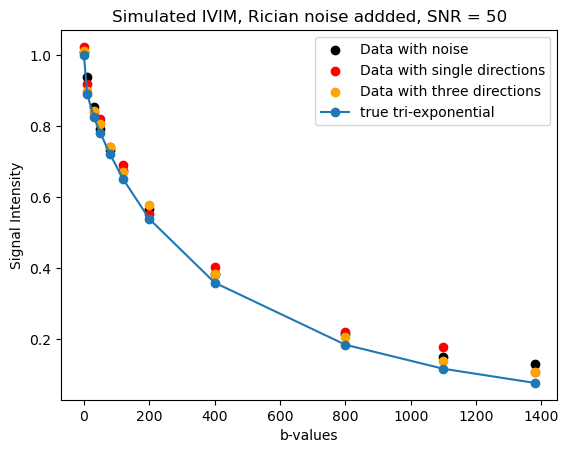

In [6]:


pl.scatter(b_values11,SI_noise,color = 'black', label = 'Data with noise')
pl.scatter(b_values11,SI_est_noise_single,color = 'red', label = 'Data with single directions')
pl.scatter(b_values11,SI_est_noise_av,color = 'orange', label = 'Data with three directions')


pl.plot(b_values11,Est_signal_true,label = 'true tri-exponential', marker = 'o')
pl.title('Simulated IVIM, Rician noise addded, SNR = 50')
pl.xlabel('b-values')
pl.ylabel('Signal Intensity')
pl.legend()
pl.show()



# Now need to fit it and see how much worse it is compared to truth.

# just export it as an excel file and then fit it... 


In [7]:
def ExportToDF(df, IdentifyingInfo, data):
    if isinstance(data, list):
        Export = data
        Export.insert(0, IdentifyingInfo)
        df.loc[ len(df),: ] = Export
    else:
        Export = data.tolist()
        Export.insert(0, IdentifyingInfo)
        df.loc[ len(df),: ] = Export
    return df
    

In [62]:
fastFA = np.abs(np.random.normal(0.09, .04,n))
medFA = np.abs(np.random.normal(0.12, 0.03,n))
slowFA = np.abs(np.random.normal(0.18, 0.02,n))

#diffusion coefficients 
#D_traces = [0.180, 0.0058, 0.0015] #true D coefficients
fastD = np.abs(np.random.normal(0.07, 0.009,n))
medD = np.abs(np.random.normal(0.010, 0.0025,n))
slowD = np.abs(np.random.normal(0.0015, 0.00075,n))


# fractions
fastfracs = np.abs(np.random.normal(.10, 0.05,n))
medfracs = np.abs(np.random.normal(.30, 0.015,n))
slowfracs = np.abs(np.random.normal(.60, 0.10,n)) #changed May 29th to ensure they add to 1
#slowfracs = np.ones(n) - fastfracs - medfracs

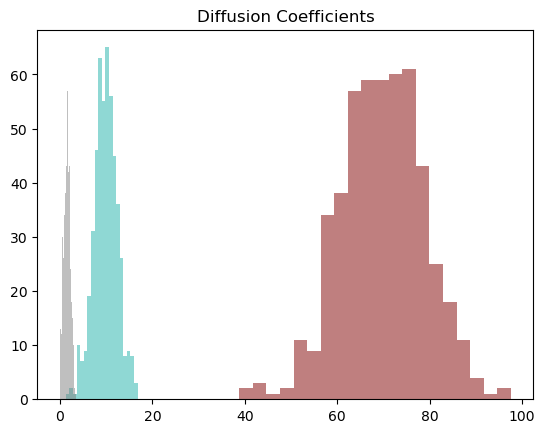

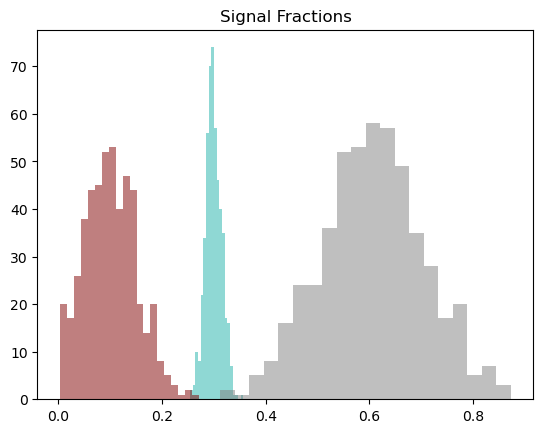

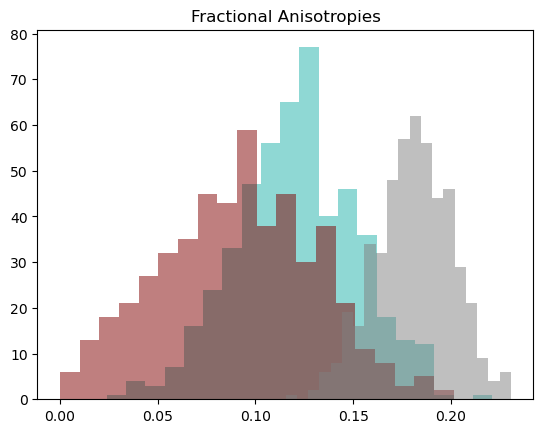

In [63]:
pl.hist(medD*1000,color = 'lightseagreen',bins=20,alpha=.5)
pl.hist(fastD*1000,color = 'maroon',bins=20, alpha = .5)
pl.hist(slowD*1000,color = 'grey',bins=20, alpha = .5)
pl.title('Diffusion Coefficients')
pl.show()

pl.hist(medfracs,color = 'lightseagreen',bins=20,alpha=.5)
pl.hist(fastfracs,color = 'maroon',bins=20, alpha = .5)
pl.hist(slowfracs,color = 'grey',bins=20, alpha = .5)
pl.title('Signal Fractions')
pl.show()

pl.hist(medFA,color = 'lightseagreen',bins=20,alpha=.5)
pl.hist(fastFA,color = 'maroon',bins=20, alpha = .5)
pl.hist(slowFA,color = 'grey',bins=20, alpha = .5)
pl.title('Fractional Anisotropies')
pl.show()


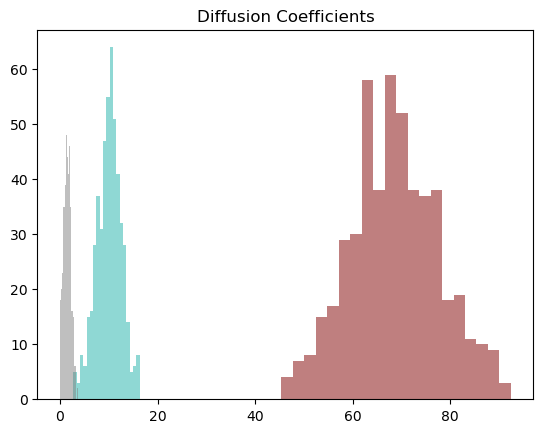

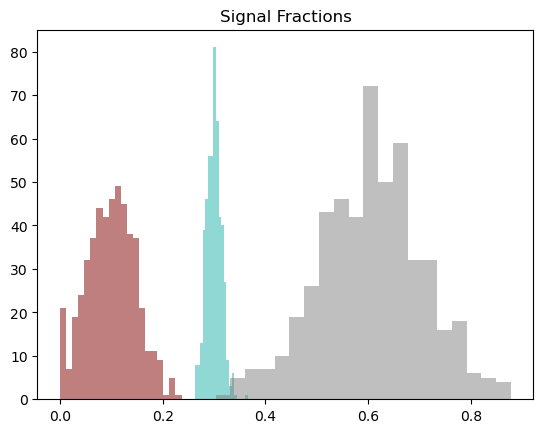

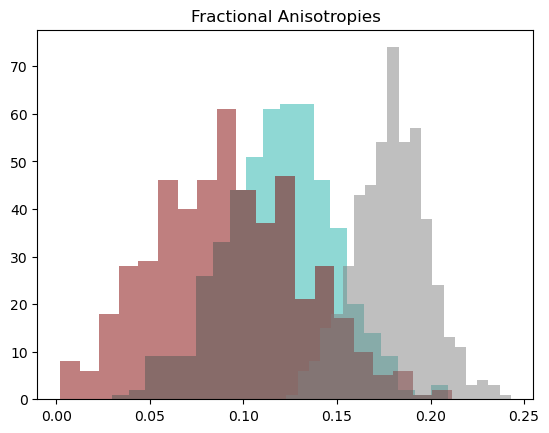

In [64]:
# Run it 500 times... get 500 'voxels'
# save it with 11 b values and with 9 b values
n = 500
#anisotropies
#est_FAS = [.09,.12,.18] #true fractional anisotropy
fastFA = np.abs(np.random.normal(0.09, 0.04,n))
medFA = np.abs(np.random.normal(0.12, 0.03,n))
slowFA = np.abs(np.random.normal(0.18, 0.02,n))

#diffusion coefficients 
#D_traces = [0.180, 0.0058, 0.0015] #true D coefficients
fastD = np.abs(np.random.normal(0.07, 0.009,n))
medD = np.abs(np.random.normal(0.010, 0.0025,n))
slowD = np.abs(np.random.normal(0.0015, 0.00075,n))


# fractions
fastfracs = np.abs(np.random.normal(.10, 0.05,n))
medfracs = np.abs(np.random.normal(.30, 0.015,n))
slowfracs = np.abs(np.random.normal(.60, 0.10,n)) #changed May 29th to ensure they add to 1
#slowfracs = np.ones(n) - fastfracs - medfracs

df_True = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800','b1100','b1380'])
df_TrueNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800','b1100','b1380'])
df_SingleNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800','b1100','b1380'])
df_AveragedNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800','b1100','b1380'])
df_TrueParams = pd.DataFrame(columns = ['Run Number', 'true fast fraction', 'true med fraction', 'true slow fraction', 'true fast diffusion', 'true med diffusion', 'true slow diffusion', 'true fast FA', 'true med FA', 'true slow FA', 'fast rotx', 'fast roty', 'fast rotz','med rotx', 'med roty', 'med rotz','slow rotx', 'slow roty', 'slow rotz'])
for j in range(n):
    IdentifyingInfo = 'Run Number ' + str(j)
    est_FAs = [fastFA[j], medFA[j], slowFA[j]]
    D_traces = [fastD[j], medD[j], slowD[j]]

    # assume 3 random sets of orientations for fast, middle, and slow compartments
    fast_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    med_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    slow_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)

    assumed_rots = [fast_rot, med_rot, slow_rot]

    # generate the 3 ellipsoids: 
    fast_compartment, med_compartment, slow_compartment = CreateThreeEllipsoidalCompartments(est_FAS,assumed_rots)
    
    #get diffusion from single direction, and averaged
    D_single, D_averaged= GetOrthogonalD_thetas(D_traces,fast_compartment, med_compartment, slow_compartment, thetaxyz)
    
    # generate signal.
    b_values11 = np.array([0,10,30,50,80,120,200,400,800, 1100, 1380]) # medium range 11 b values 0 - 1380

    # generate the signal from single direction
    Est_signal_single = triexp_func(b_values11,fastfracs[j],medfracs[j],slowfracs[j], D_single[0], D_single[1], D_single[2])
    SI_est_noise_single = NoiseRice(Est_signal_single, 0.02)
    ExportToDF(df_SingleNoise, IdentifyingInfo, SI_est_noise_single )

    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func(b_values11,fastfracs[j],medfracs[j],slowfracs[j], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 0.02)
    ExportToDF(df_AveragedNoise, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = triexp_func(b_values11,fastfracs[j],medfracs[j],slowfracs[j], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True, IdentifyingInfo, Est_signal_true )

    SI_noise = NoiseRice(Est_signal_true, .02)
    ExportToDF(df_TrueNoise, IdentifyingInfo, SI_noise )
    
    # with important params
    norm = fastfracs[j] + medfracs[j] + slowfracs[j]
    Parameters = np.array([fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm,fastD[j], medD[j], slowD[j], fastFA[j], medFA[j], slowFA[j], fast_rot[0],fast_rot[1],fast_rot[2], med_rot[0],med_rot[1],med_rot[2], slow_rot[0],slow_rot[1],slow_rot[2]])
    ExportToDF(df_TrueParams, IdentifyingInfo, Parameters)

    

with pd.ExcelWriter('MultiExpSimulatedCurves_20240611.xlsx',mode='a') as writer:  
    df_True.to_excel(writer,sheet_name='TrueData')  
    df_TrueNoise.to_excel(writer,sheet_name='TrueNoise')  
    df_SingleNoise.to_excel(writer,sheet_name='SingleNoise')  

    df_AveragedNoise.to_excel(writer,sheet_name='AveragedNoise')  

    df_TrueParams.to_excel(writer,sheet_name='Parameters')  


    
    

    
pl.hist(medD*1000,color = 'lightseagreen',bins=20,alpha=.5)
pl.hist(fastD*1000,color = 'maroon',bins=20, alpha = .5)
pl.hist(slowD*1000,color = 'grey',bins=20, alpha = .5)
pl.title('Diffusion Coefficient Distribution')
pl.xlabel('D $10^{-3}mm^2/s$')
pl.ylabel('Count')
pl.show()

pl.hist(medfracs,color = 'lightseagreen',bins=20,alpha=.5)
pl.hist(fastfracs,color = 'maroon',bins=20, alpha = .5)
pl.hist(slowfracs,color = 'grey',bins=20, alpha = .5)
pl.title('Signal Fraction Distribution')
pl.xlabel('Fraction')
pl.ylabel('Count')
pl.show()

pl.hist(medFA,color = 'lightseagreen',bins=20,alpha=.5)
pl.hist(fastFA,color = 'maroon',bins=20, alpha = .5)
pl.hist(slowFA,color = 'grey',bins=20, alpha = .5)
pl.title('Fractional Anisotropy distribution')
pl.xlabel('FA')
pl.ylabel('Count')
pl.show()


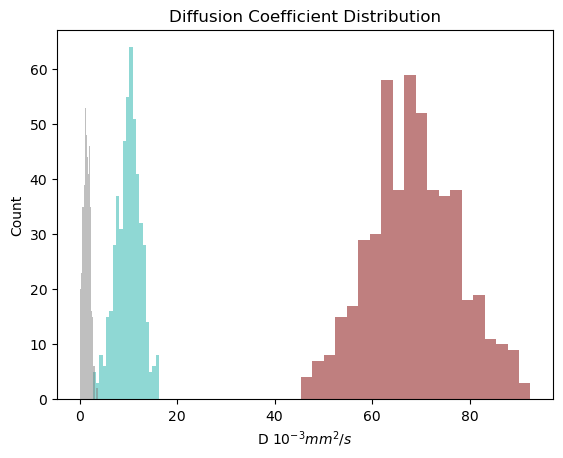

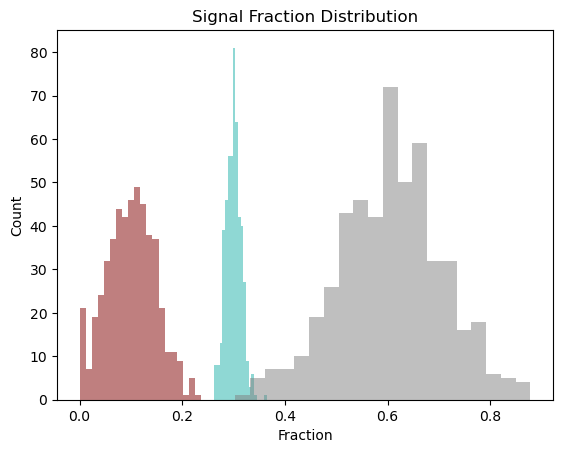

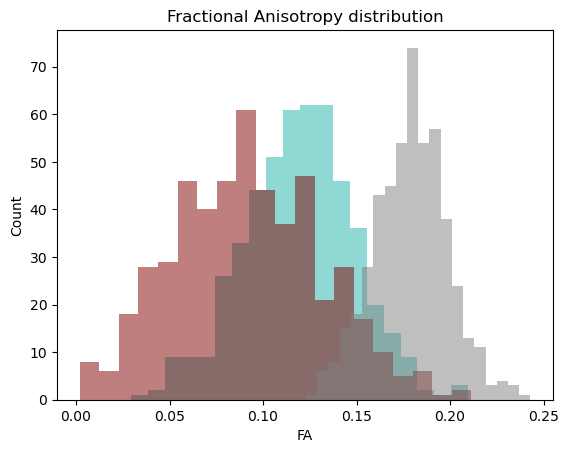

In [67]:

    
pl.hist(medD*1000,color = 'lightseagreen',bins=20,alpha=.5)
pl.hist(fastD*1000,color = 'maroon',bins=20, alpha = .5)
pl.hist(slowD*1000,color = 'grey',bins=20, alpha = .5)
pl.title('Diffusion Coefficient Distribution')
pl.xlabel('D $10^{-3}mm^2/s$')
pl.ylabel('Count')
pl.show()

pl.hist(medfracs,color = 'lightseagreen',bins=20,alpha=.5)
pl.hist(fastfracs,color = 'maroon',bins=20, alpha = .5)
pl.hist(slowfracs,color = 'grey',bins=20, alpha = .5)
pl.title('Signal Fraction Distribution')
pl.xlabel('Fraction')
pl.ylabel('Count')
pl.show()

pl.hist(medFA,color = 'lightseagreen',bins=20,alpha=.5)
pl.hist(fastFA,color = 'maroon',bins=20, alpha = .5)
pl.hist(slowFA,color = 'grey',bins=20, alpha = .5)
pl.title('Fractional Anisotropy distribution')
pl.xlabel('FA')
pl.ylabel('Count')
pl.show()


Maintaining 10 b-values while increasing the range to b=0– 1,100 s/mm2 improved the AUC to 0.83. Using a medium b-value range of b=0–1,380 s/mm2 (with 15 b-values) improved the AUC to >0.90,

from Gladytz paper

# trying tri-exp fit to the df_True


In [183]:
# trying tri-exp fit to the df_True
TrueFracs = []
TrueDiffs = []
FitFracs = []
FitDiffs = []
for j in range(500):
    norm = df_TrueParams['true fast fraction'].iloc[j]+df_TrueParams['true med fraction'].iloc[j]+df_TrueParams['true slow fraction'].iloc[j]
    #pl.plot(b_values11,df_True.iloc[j,1:]/norm)
    #pl.scatter(b_values11,triexp_func(b_values11, df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j],df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]))
    TrueParameters.append(df_True.iloc[j,1:])
    popt, pcov = curve_fit(triexp_func, b_values11,df_True.iloc[j,1:],p0=[.1,.2,.7, 0.1, 0.01, 0.001],bounds=(0, [1,1,1,.1,.1,.1]))
    #pl.scatter(b_values11,triexp_func(b_values11,*popt))
    
    ## order popt from fast to slow diffusion
    norm_popt = popt[0]+popt[1]+popt[2]
    idx_sort = popt[3:6].argsort()
    fracs = popt[0:3]/norm_popt
    diffusions = popt[3:6]
    fracs=fracs[idx_sort[::-1]]
    diffusions=diffusions[idx_sort[::-1]]
    #print(*[df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j],df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    
    ## order given true values from fast to slow just in case
    givenfracs = np.array([df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j]])
    givendiffusions = np.array([df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    idx_sort = givendiffusions.argsort()
    givenfracs = givenfracs[idx_sort[::-1]]
    givendiffusions = givendiffusions[idx_sort[::-1]]

    TrueFracs.append(list(givenfracs))
    TrueDiffs.append(list(givendiffusions))
    FitFracs.append(list(fracs))
    FitDiffs.append(list(diffusions))
    

In [226]:
TrueDiffs

[[0.07830165358652146, 0.010304893888062919, 0.0006135893089041861],
 [0.08256184443665106, 0.010424266593202565, 0.0011098990969239818],
 [0.0815432381086686, 0.010282012729489576, 0.0031570724357253715],
 [0.07439775788601898, 0.011132425993915078, 0.001370911039124764],
 [0.06619551920517493, 0.013269150031925785, 0.00040422132827626323],
 [0.06783812545612862, 0.009564237364821067, 0.002594158524595706],
 [0.06109732094816404, 0.009117373639927477, 0.002323496155077506],
 [0.061615088272998914, 0.012084518088955117, 0.0013008443527442429],
 [0.06792839005269553, 0.01583009056575695, 0.0022416980295543914],
 [0.07959831713695502, 0.007377217875870649, 0.0012444821128798024],
 [0.08108785989591619, 0.013297040408630272, 2.8784251778415703e-05],
 [0.08134122103122356, 0.013652645869168938, 0.002730820433941356],
 [0.07923076587802866, 0.005493842929782994, 0.0012060555652949894],
 [0.05583212509080773, 0.012898411055576776, 0.00128638203760451],
 [0.07094280803365152, 0.01046271892724

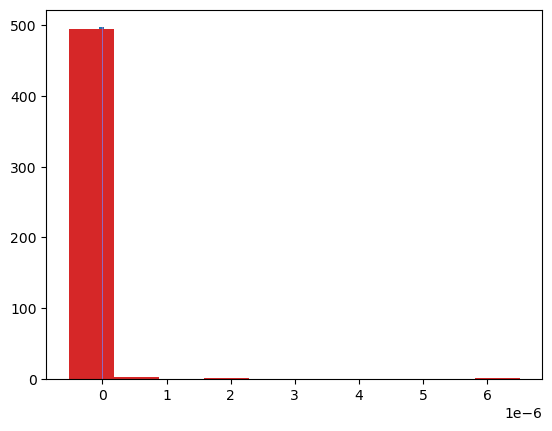

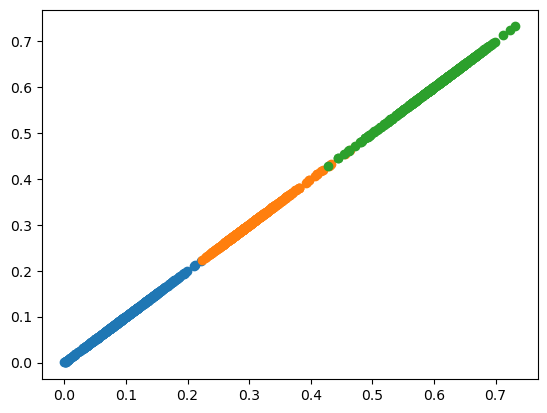

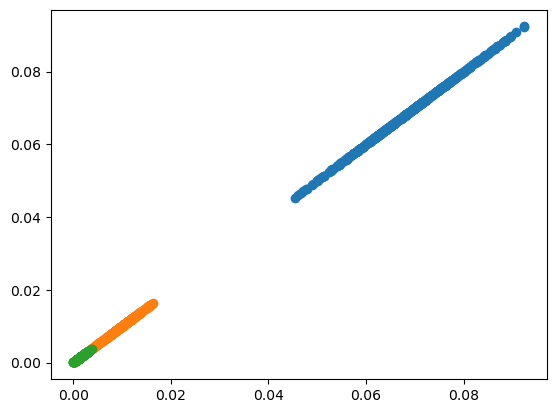

In [185]:
FracDifferences = np.array(TrueFracs)-np.array(FitFracs)
FastFracDifference = FracDifferences[:,0]
pl.hist(FastFracDifference)
MedFracDifference = FracDifferences[:,1]
pl.hist(MedFracDifference)
SlowFracDifference = FracDifferences[:,2]
pl.hist(SlowFracDifference)

DiffusionDifferences = np.array(TrueDiffs)-np.array(FitDiffs)
FastDiffusionDifference = DiffusionDifferences[:,0]
pl.hist(FastDiffusionDifference)
MedDiffusionDifference = DiffusionDifferences[:,1]
pl.hist(MedDiffusionDifference)
SlowDiffusionDifference = DiffusionDifferences[:,2]
pl.hist(SlowDiffusionDifference)
pl.show()

pl.scatter(np.array(TrueFracs)[:,0],np.array(FitFracs)[:,0],label= 'fast frac')

pl.scatter(np.array(TrueFracs)[:,1],np.array(FitFracs)[:,1], label = 'med frac')
pl.scatter(np.array(TrueFracs)[:,2],np.array(FitFracs)[:,2], label = 'slow frac')
pl.show()

pl.scatter(np.array(TrueDiffs)[:,0],np.array(FitDiffs)[:,0],label= 'fast diffs')
pl.scatter(np.array(TrueDiffs)[:,1],np.array(FitDiffs)[:,1], label = 'med diffs')
pl.scatter(np.array(TrueDiffs)[:,2],np.array(FitDiffs)[:,2], label = 'slow diffs')
pl.show()




# now with averaged data, comparing fits

In [186]:
# trying tri-exp fit to the df_True
TrueFracs = []
TrueDiffs = []
FitFracs = []
FitDiffs = []
for j in range(500):
    #norm = df_TrueParams['true fast fraction'].iloc[j]+df_TrueParams['true med fraction'].iloc[j]+df_TrueParams['true slow fraction'].iloc[j]
    #pl.plot(b_values11,df_True.iloc[j,1:]/norm)
    #pl.scatter(b_values11,triexp_func(b_values11, df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j],df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]))
    popt, pcov = curve_fit(triexp_func, b_values11,df_AveragedNoise.iloc[j,1:],p0=[.1,.2,.7, 0.1, 0.01, 0.001],bounds=(0, [1,1,1,.1,.1,.1]),maxfev=10000)
    #pl.scatter(b_values11,triexp_func(b_values11,*popt))
    
    ## order popt from fast to slow diffusion
    norm_popt = popt[0]+popt[1]+popt[2]
    idx_sort = popt[3:6].argsort()
    fracs = popt[0:3]/norm_popt
    diffusions = popt[3:6]
    fracs=fracs[idx_sort[::-1]]
    diffusions=diffusions[idx_sort[::-1]]
    #print(*[df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j],df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    
    ## order given true values from fast to slow just in case
    givenfracs = np.array([df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j]])
    givendiffusions = np.array([df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    idx_sort = givendiffusions.argsort()
    givenfracs = givenfracs[idx_sort[::-1]]
    givendiffusions = givendiffusions[idx_sort[::-1]]

    TrueFracs.append(list(givenfracs))
    TrueDiffs.append(list(givendiffusions))
    FitFracs.append(list(fracs))
    FitDiffs.append(list(diffusions))
    

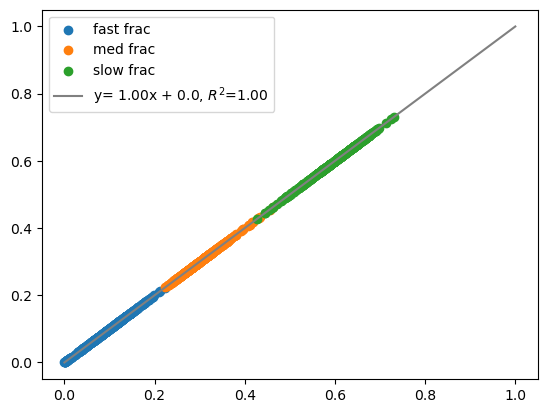

SignificanceResult(statistic=1.0, pvalue=0.0)
fast frac mean difference = 0.00000± 0.00000, 0.00003
med frac mean difference = -0.00000± 0.00000, -0.00000
slow frac mean difference = 0.00000± 0.00000, 0.00000


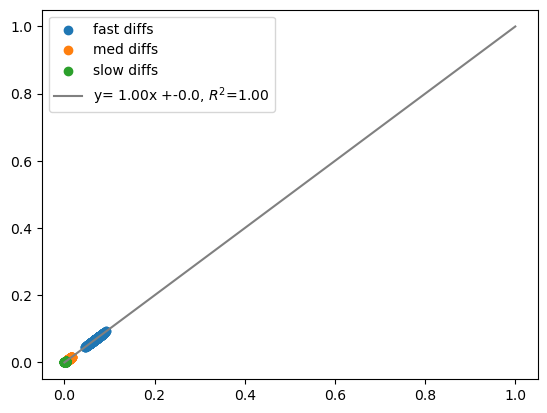

SignificanceResult(statistic=1.0, pvalue=0.0)
fast diffusion mean difference = -0.00000± 0.00000, -0.00004
med diffusion mean difference = 0.00000± 0.00000, 0.00000
slow diffusion mean difference = 0.00000± 0.00000, 0.00000


In [232]:

pl.scatter(np.array(TrueFracs)[:,0],np.array(FitFracs)[:,0],label= 'fast frac')
pl.scatter(np.array(TrueFracs)[:,1],np.array(FitFracs)[:,1], label = 'med frac')
pl.scatter(np.array(TrueFracs)[:,2],np.array(FitFracs)[:,2], label = 'slow frac')

x = np.linspace(0,1,10)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.array(TrueFracs).reshape(-1), np.array(FitFracs).reshape(-1))
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()
print(scipy.stats.spearmanr(np.array(TrueFracs).reshape(-1), np.array(FitFracs).reshape(-1)))
print(f'fast frac mean difference = {np.mean(np.array(FitFracs)[:,0]-np.array(TrueFracs)[:,0]):.5f}± {np.std(np.array(TrueFracs)[:,0]-np.array(FitFracs)[:,0]):.5f}, {100*np.mean((np.array(FitFracs)[:,0]-np.array(TrueFracs)[:,0])/np.array(TrueFracs)[:,0]):.5f}')
print(f'med frac mean difference = {np.mean(np.array(FitFracs)[:,1]-np.array(TrueFracs)[:,1]):.5f}± {np.std(np.array(TrueFracs)[:,1]-np.array(FitFracs)[:,1]):.5f}, {100*np.mean((np.array(FitFracs)[:,1]-np.array(TrueFracs)[:,1])/np.array(TrueFracs)[:,1]):.5f}')
print(f'slow frac mean difference = {np.mean(np.array(FitFracs)[:,2]-np.array(TrueFracs)[:,2]):.5f}± {np.std(np.array(TrueFracs)[:,2]-np.array(FitFracs)[:,2]):.5f}, {100*np.mean((np.array(FitFracs)[:,2]-np.array(TrueFracs)[:,2])/np.array(TrueFracs)[:,2]):.5f}')



pl.scatter(np.array(TrueDiffs)[:,0],np.array(FitDiffs)[:,0],label= 'fast diffs')
pl.scatter(np.array(TrueDiffs)[:,1],np.array(FitDiffs)[:,1], label = 'med diffs')
pl.scatter(np.array(TrueDiffs)[:,2],np.array(FitDiffs)[:,2], label = 'slow diffs')
x = np.linspace(0,1,10)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.array(TrueDiffs).reshape(-1), np.array(FitDiffs).reshape(-1))
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()
print(scipy.stats.spearmanr(np.array(TrueDiffs).reshape(-1), np.array(FitDiffs).reshape(-1)))
print(f'fast diffusion mean difference = {np.mean(np.array(FitDiffs)[:,0]-np.array(TrueDiffs)[:,0]):.5f}± {np.std(np.array(TrueDiffs)[:,0]-np.array(FitDiffs)[:,0]):.5f}, {100*np.mean((np.array(FitDiffs)[:,0]-np.array(TrueDiffs)[:,0])/np.array(TrueDiffs)[:,0]):.5f}')
print(f'med diffusion mean difference = {np.mean(np.array(FitDiffs)[:,1]-np.array(TrueDiffs)[:,1]):.5f}± {np.std(np.array(TrueDiffs)[:,1]-np.array(FitDiffs)[:,1]):.5f}, {100*np.mean((np.array(FitDiffs)[:,1]-np.array(TrueDiffs)[:,1])/np.array(TrueDiffs)[:,1]):.5f}')
print(f'slow diffusion mean difference = {np.mean(np.array(FitDiffs)[:,2]-np.array(TrueDiffs)[:,2]):.5f}± {np.std(np.array(TrueDiffs)[:,2]-np.array(FitDiffs)[:,2]):.5f}, {100*np.mean((np.array(FitDiffs)[:,2]-np.array(TrueDiffs)[:,2])/np.array(TrueDiffs)[:,2]):.5f}')



# now the effect of combined fD!

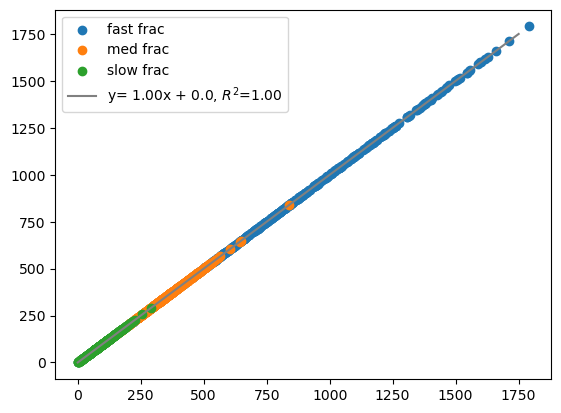

SignificanceResult(statistic=1.0, pvalue=0.0)
All fD difference = -0.00000 ± 0.00000, -0.00000%
fast fD mean difference = -0.00000± 0.00000, -0.00000%
med fD mean difference = -0.00000± 0.00000, -0.00000%
slow fD mean difference = 0.00000± 0.00000, -0.00000%


In [233]:
TruefastfDs= 1000*np.array(TrueFracs)[:,0]*np.array(TrueDiffs)[:,0]
FitfastfDs = 1000*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0]

TruemedfDs= 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1]
FitmedfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

TrueslowfDs= 1000*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2]
FitslowfDs = 1000*np.array(FitFracs)[:,2]*np.array(FitDiffs)[:,2]


pl.scatter(112500*np.array(TrueFracs)[:,0]*np.array(TrueDiffs)[:,0], 112500*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0],label= 'fast frac')
pl.scatter(112500*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1], 112500*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1],label= 'med frac')
pl.scatter(112500*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2], 112500*np.array(FitFracs)[:,2]*np.array(FitDiffs)[:,2],label= 'slow frac')

x = np.linspace(0,1750,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress((np.array(TrueFracs)*np.array(TrueDiffs)).reshape(-1), (np.array(FitFracs)*np.array(FitDiffs)).reshape(-1))
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()
print(scipy.stats.spearmanr((np.array(TrueFracs)*np.array(TrueDiffs)).reshape(-1), (np.array(FitFracs)*np.array(FitDiffs)).reshape(-1)))
print(f'All fD difference = {np.mean((np.array(FitFracs)*np.array(FitDiffs)).reshape(-1)-(np.array(TrueFracs)*np.array(TrueDiffs)).reshape(-1)):.5f} ± {np.std((np.array(FitFracs)*np.array(FitDiffs)).reshape(-1)-(np.array(TrueFracs)*np.array(TrueDiffs)).reshape(-1)):.5f}, {100*np.median(((np.array(FitFracs)*np.array(FitDiffs)).reshape(-1)-(np.array(TrueFracs)*np.array(TrueDiffs)).reshape(-1))/(np.array(TrueFracs)*np.array(TrueDiffs)).reshape(-1)):.5f}%')
print(f'fast fD mean difference = {np.mean(FitfastfDs-TruefastfDs):.5f}± {np.std(FitfastfDs-TruefastfDs):.5f}, {100*np.median((FitfastfDs-TruefastfDs)/TruefastfDs):.5f}%')
print(f'med fD mean difference = {np.mean(FitmedfDs-TruemedfDs):.5f}± {np.std(FitmedfDs-TruemedfDs):.5f}, {100*np.median((FitmedfDs-TruemedfDs)/TruemedfDs):.5f}%')
print(f'slow fD mean difference = {np.mean(FitslowfDs-TrueslowfDs):.5f}± {np.std(FitslowfDs-TrueslowfDs):.5f}, {100*np.median((FitslowfDs-TrueslowfDs)/TrueslowfDs):.5f}%')


# using the isotropic true with no noise

In [234]:
# trying tri-exp fit to the df_True
TrueFracs = []
TrueDiffs = []
FitFracs = []
FitDiffs = []
for j in range(500):
    #norm = df_TrueParams['true fast fraction'].iloc[j]+df_TrueParams['true med fraction'].iloc[j]+df_TrueParams['true slow fraction'].iloc[j]
    #pl.plot(b_values11,df_True.iloc[j,1:]/norm)
    #pl.scatter(b_values11,triexp_func(b_values11, df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j],df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]))
    popt, pcov = curve_fit(triexp_func, b_values11,df_True.iloc[j,1:],p0=[.1,.2,.7, 0.1, 0.01, 0.001],bounds=(0, [1,1,1,.1,.1,.1]),maxfev=10000)
    #pl.scatter(b_values11,triexp_func(b_values11,*popt))
    
    ## order popt from fast to slow diffusion
    norm_popt = popt[0]+popt[1]+popt[2]
    idx_sort = popt[3:6].argsort()
    fracs = popt[0:3]/norm_popt
    diffusions = popt[3:6]
    fracs=fracs[idx_sort[::-1]]
    diffusions=diffusions[idx_sort[::-1]]
    #print(*[df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j],df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    
    ## order given true values from fast to slow just in case
    givenfracs = np.array([df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j]])
    givendiffusions = np.array([df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    idx_sort = givendiffusions.argsort()
    givenfracs = givenfracs[idx_sort[::-1]]
    givendiffusions = givendiffusions[idx_sort[::-1]]

    TrueFracs.append(list(givenfracs))
    TrueDiffs.append(list(givendiffusions))
    FitFracs.append(list(fracs))
    FitDiffs.append(list(diffusions))
    

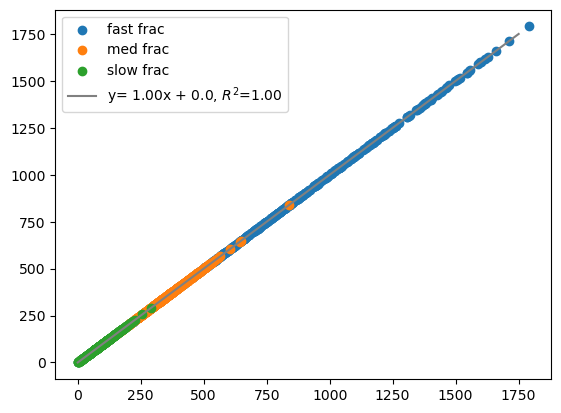

SignificanceResult(statistic=1.0, pvalue=0.0)
All fD difference = -0.00000 ± 0.00000, -0.00000%
fast fD mean difference = -0.00000± 0.00000, -0.00000%
med fD mean difference = -0.00000± 0.00000, -0.00000%
slow fD mean difference = 0.00000± 0.00000, -0.00000%


In [235]:
TruefastfDs= 1000*np.array(TrueFracs)[:,0]*np.array(TrueDiffs)[:,0]
FitfastfDs = 1000*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0]

TruemedfDs= 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1]
FitmedfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

TrueslowfDs= 1000*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2]
FitslowfDs = 1000*np.array(FitFracs)[:,2]*np.array(FitDiffs)[:,2]


pl.scatter(112500*np.array(TrueFracs)[:,0]*np.array(TrueDiffs)[:,0], 112500*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0],label= 'fast frac')
pl.scatter(112500*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1], 112500*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1],label= 'med frac')
pl.scatter(112500*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2], 112500*np.array(FitFracs)[:,2]*np.array(FitDiffs)[:,2],label= 'slow frac')

x = np.linspace(0,1750,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress((np.array(TrueFracs)*np.array(TrueDiffs)).reshape(-1), (np.array(FitFracs)*np.array(FitDiffs)).reshape(-1))
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()
print(scipy.stats.spearmanr((np.array(TrueFracs)*np.array(TrueDiffs)).reshape(-1), (np.array(FitFracs)*np.array(FitDiffs)).reshape(-1)))
print(f'All fD difference = {np.mean((np.array(FitFracs)*np.array(FitDiffs)).reshape(-1)-(np.array(TrueFracs)*np.array(TrueDiffs)).reshape(-1)):.5f} ± {np.std((np.array(FitFracs)*np.array(FitDiffs)).reshape(-1)-(np.array(TrueFracs)*np.array(TrueDiffs)).reshape(-1)):.5f}, {100*np.median(((np.array(FitFracs)*np.array(FitDiffs)).reshape(-1)-(np.array(TrueFracs)*np.array(TrueDiffs)).reshape(-1))/(np.array(TrueFracs)*np.array(TrueDiffs)).reshape(-1)):.5f}%')
print(f'fast fD mean difference = {np.mean(FitfastfDs-TruefastfDs):.5f}± {np.std(FitfastfDs-TruefastfDs):.5f}, {100*np.median((FitfastfDs-TruefastfDs)/TruefastfDs):.5f}%')
print(f'med fD mean difference = {np.mean(FitmedfDs-TruemedfDs):.5f}± {np.std(FitmedfDs-TruemedfDs):.5f}, {100*np.median((FitmedfDs-TruemedfDs)/TruemedfDs):.5f}%')
print(f'slow fD mean difference = {np.mean(FitslowfDs-TrueslowfDs):.5f}± {np.std(FitslowfDs-TrueslowfDs):.5f}, {100*np.median((FitslowfDs-TrueslowfDs)/TrueslowfDs):.5f}%')
